In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Task 1: Exploratory Data Analysis (EDA)

In [8]:
customers = pd.read_csv("/kaggle/input/customer-segment/Customers.csv")
products = pd.read_csv("/kaggle/input/customer-segment/Products.csv")
transactions = pd.read_csv("/kaggle/input/customer-segment/Transactions.csv")

In [9]:
customers_df = pd.DataFrame(customers)
products_df = pd.DataFrame(products)
transactions_df = pd.DataFrame(transactions)

# Check for missing values
print("Missing Values:\n")
print(customers_df.isnull().sum(), products_df.isnull().sum(), transactions_df.isnull().sum())

# Data statistics
print("Transactions Summary:\n", transactions_df.describe())

# Merge datasets for insights
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data = pd.merge(merged_data, products, on='ProductID')

Missing Values:

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64
Transactions Summary:
           Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


## Data overview

In [15]:

customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [16]:
products_df.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [17]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [18]:
df = pd.DataFrame(merged_data)
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


## Insights

### Insight 1: Product Popularity Trends

Most Popular Products:
                        Quantity
ProductName                    
ActiveWear Smartwatch       100
SoundWave Headphones         97
HomeSense Desk Lamp          81
ActiveWear Rug               79
SoundWave Cookbook           78


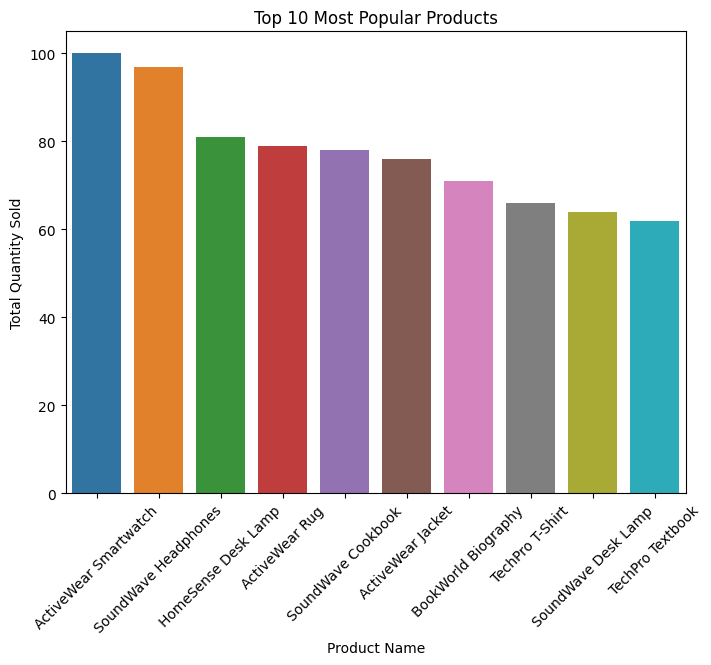

In [19]:
popular_products = merged_data.groupby('ProductName').agg({'Quantity': 'sum'}).sort_values(by='Quantity', ascending=False)
print("Most Popular Products:\n", popular_products.head())

# Visualization for Product Popularity
plt.figure(figsize=(8, 6))
sns.barplot(x=popular_products.head(10).index, y=popular_products.head(10)['Quantity'])
plt.title("Top 10 Most Popular Products")
plt.ylabel("Total Quantity Sold")
plt.xlabel("Product Name")
plt.xticks(rotation=45)
plt.show()

### Insight 2: Customer Sign-Up Trends

Customer Sign-Up Trends (by Month):
 SignupDate
4     24
2     21
9     21
3     20
11    19
5     17
10    15
1     15
7     13
12    13
6     12
8     10
Name: count, dtype: int64


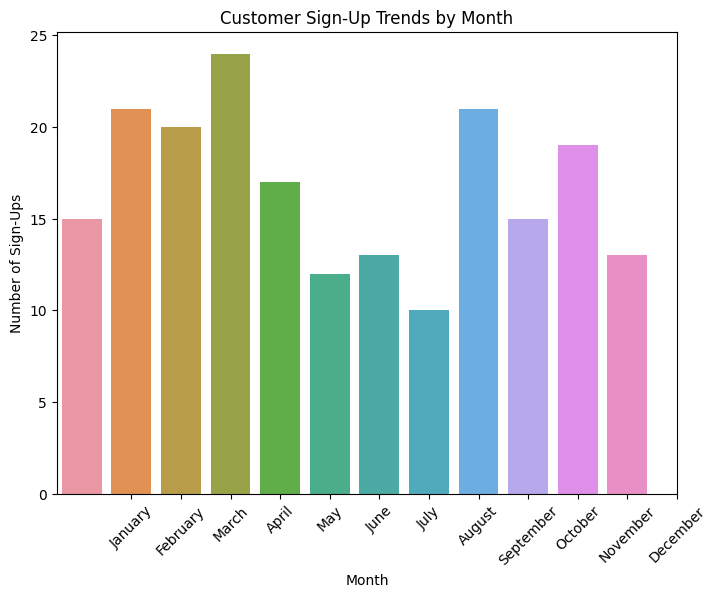

In [20]:
import calendar

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
signup_trends = customers_df['SignupDate'].dt.month.value_counts()
print("Customer Sign-Up Trends (by Month):\n", signup_trends)

# Visualization for Customer Sign-Up Trends
plt.figure(figsize=(8, 6))
sns.barplot(x=signup_trends.index, y=signup_trends.values)
plt.title("Customer Sign-Up Trends by Month")
plt.ylabel("Number of Sign-Ups")
plt.xlabel("Month")
plt.xticks(range(1, 13), calendar.month_name[1:13], rotation=45)
plt.show()

### Insight 3: High-Value Customers

Average Spending by Region:
 Region
South America    721.554474
Europe           710.489872
Asia             697.591606
North America    624.235246
Name: TotalValue, dtype: float64


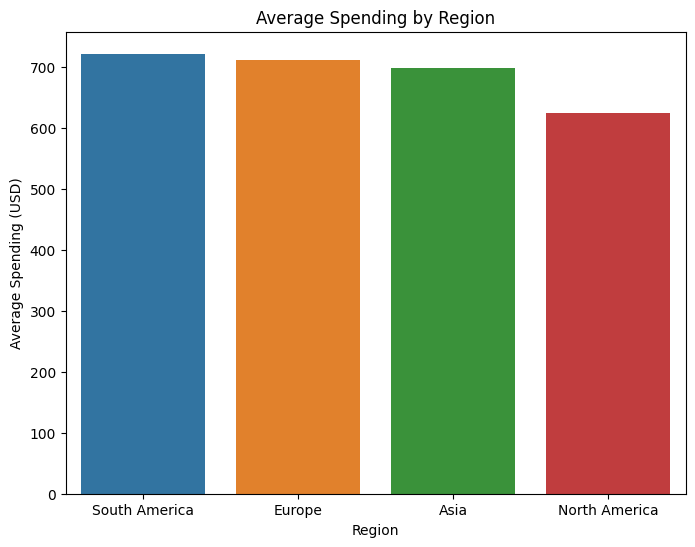

In [21]:
region_spending = merged_data.groupby('Region')['TotalValue'].mean().sort_values(ascending=False)
print("Average Spending by Region:\n", region_spending)

# Visualization for High-Value Customers
plt.figure(figsize=(8, 6))
sns.barplot(x=region_spending.index, y=region_spending.values)
plt.title("Average Spending by Region")
plt.ylabel("Average Spending (USD)")
plt.xlabel("Region")
plt.show()

### Insight 4: Impact of Discounts on Sales

Transactions with Discounts: 1135, Without Discounts: 1402


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


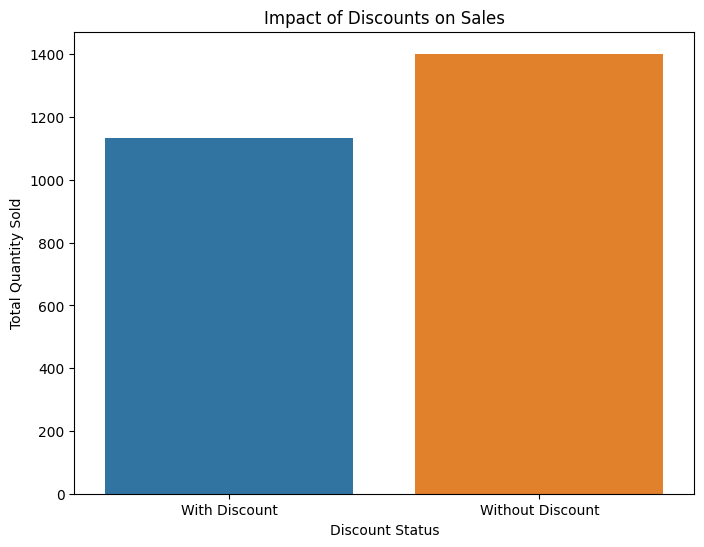

In [24]:
discount_effect = merged_data[merged_data['Price_x'] < merged_data['Price_x'].mean()]['Quantity'].sum()
no_discount_effect = merged_data[merged_data['Price_x'] >= merged_data['Price_x'].mean()]['Quantity'].sum()
print(f"Transactions with Discounts: {discount_effect}, Without Discounts: {no_discount_effect}")

# Visualization for Discounts Impact
plt.figure(figsize=(8, 6))
sns.barplot(x=['With Discount', 'Without Discount'], y=[discount_effect, no_discount_effect])
plt.title("Impact of Discounts on Sales")
plt.ylabel("Total Quantity Sold")
plt.xlabel("Discount Status")
plt.show()

### Insight 5: Transaction counts by region

Transaction Counts by Region:
 Region
South America    304
North America    244
Europe           234
Asia             218
Name: count, dtype: int64


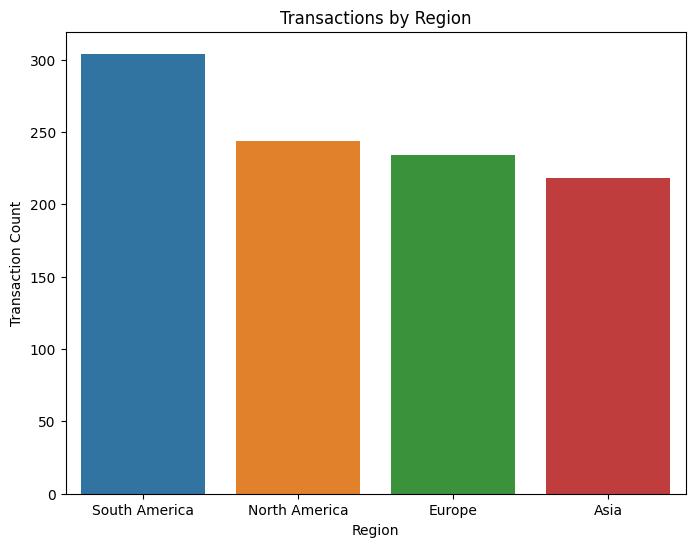

In [25]:

region_counts = merged_data['Region'].value_counts()
print("Transaction Counts by Region:\n", region_counts)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title("Transactions by Region")
plt.ylabel("Transaction Count")
plt.xlabel("Region")
plt.show()

# Task 2: Lookalike Model

In [26]:
# Feature engineering
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).reset_index()
transaction_summary.rename(columns={'TotalValue': 'TotalSpent', 'TransactionID': 'TransactionCount'}, inplace=True)

# Merge customer data
customer_profiles = pd.merge(customers, transaction_summary, on='CustomerID', how='left')
customer_profiles.fillna(0, inplace=True)

# Normalize features
scaler = StandardScaler()
features = ['TotalSpent', 'TransactionCount']
customer_profiles[features] = scaler.fit_transform(customer_profiles[features])

# Similarity calculation
similarity_matrix = cosine_similarity(customer_profiles[features])

# Get top 3 similar customers for first 20 customers
lookalikes = {}
for i in range(20):
    customer_id = customer_profiles.iloc[i]['CustomerID']
    similarities = list(enumerate(similarity_matrix[i]))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    top_3 = [(customer_profiles.iloc[idx]['CustomerID'], score) for idx, score in similarities[1:4]]
    lookalikes[customer_id] = top_3

# Save to Lookalike.csv
lookalike_df = pd.DataFrame({"CustomerID": lookalikes.keys(), "Lookalikes": lookalikes.values()})
lookalike_df.to_csv("Lookalike.csv", index=False)

In [27]:
lookalike_df.head()

,CustomerID,Lookalikes
0,C0001,"[(C0030, 1.0), (C0038, 1.0), (C0055, 1.0)]"
1,C0002,"[(C0029, 0.9998164502862076), (C0199, 0.999488..."
2,C0003,"[(C0095, 0.9999982967950394), (C0150, 0.999987..."
3,C0004,"[(C0067, 0.9999900346224984), (C0021, 0.999867..."
4,C0005,"[(C0130, 0.9999955557509856), (C0144, 0.999987..."


# Task 3: Customer Segmentation

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DB Index: 0.855819040499996
Silhouette Score: 0.39235898151283716


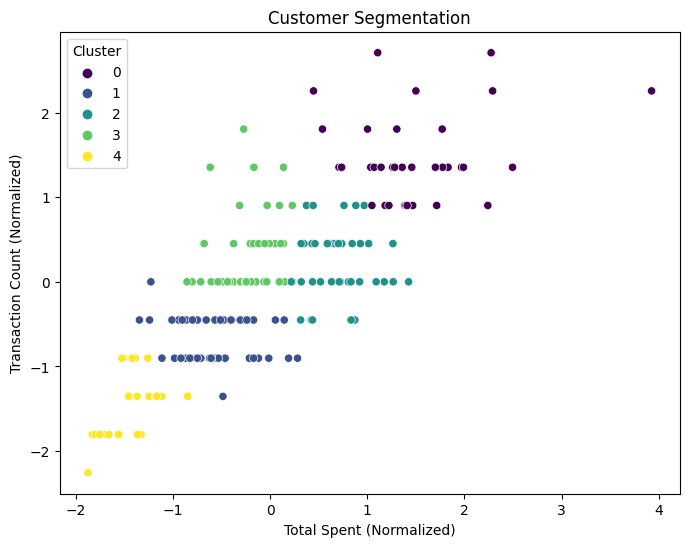

In [28]:
# def perform_clustering(customers, transactions):
# Feature engineering
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).reset_index()
transaction_summary.rename(columns={'TotalValue': 'TotalSpent', 'TransactionID': 'TransactionCount'}, inplace=True)

# Merge customer data
customer_profiles = pd.merge(customers, transaction_summary, on='CustomerID', how='left')
customer_profiles.fillna(0, inplace=True)

# Normalize features
scaler = StandardScaler()
features = ['TotalSpent', 'TransactionCount']
customer_profiles[features] = scaler.fit_transform(customer_profiles[features])

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles[features])

# Evaluate clustering
db_index = davies_bouldin_score(customer_profiles[features], customer_profiles['Cluster'])
silhouette_avg = silhouette_score(customer_profiles[features], customer_profiles['Cluster'])
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_profiles[features[0]], 
    y=customer_profiles[features[1]], 
    hue=customer_profiles['Cluster'], 
    palette="viridis"
)
plt.title("Customer Segmentation")
plt.xlabel("Total Spent (Normalized)")
plt.ylabel("Transaction Count (Normalized)")
plt.legend(title="Cluster")
plt.show()